# Recognition System for Rice Leaf Diseases

In [1]:
import pandas as pd
import numpy as np
import cv2
from PIL import Image
from skimage.color import rgb2gray, rgb2hsv
from skimage import transform

import seaborn as sb

import sys
import gc
import torch

import os
import pickle
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split, StratifiedKFold

from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,CSVLogger
from tensorflow.keras import regularizers
from tensorflow.python.client import device_lib
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Activation, Lambda, MaxPool2D, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#Visualization and Plotting
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

# Set GPU for faster computations

In [2]:
#Ako'y ALAPIN NG GPU KOOOOOOO
print(device_lib.list_local_devices())
phy_device = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(phy_device[0],True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17435885812570896232
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4183621632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10569897079099912986
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:06:00.0, compute capability: 7.5"
]


# 1. Prepare all necessary components 

## 1.1a Loading Dataset with 3 classes (Blight, Brown spots, Leaf smut)

In [3]:
classes = ["Bacterial leaf blight", "Brown spot", "Leaf smut"]

In [ ]:
#Loading Pickled training and testing datasets
X_train = pickle.load(open('small_dataset\\X_train_3_classes.pickle', 'rb'))
y_train = pickle.load(open('small_dataset\\y_train_3_classes.pickle', 'rb'))

X_train = X_train/255
y_train = np.array(y_train)

X_val = pickle.load(open('small_dataset\\X_val_3_classes.pickle', 'rb'))
y_val = pickle.load(open('small_dataset\\y_val_3_classes.pickle', 'rb'))

X_val = X_val/255
y_val = np.array(y_val)

X_test = pickle.load(open('small_dataset\\X_test_3_classes.pickle', 'rb'))
y_test = pickle.load(open('small_dataset\\y_test_3_classes.pickle', 'rb'))

X_test = X_test/255
y_test = np.array(y_test)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

## 1.1b Dataset for K-fold Cross Validation

In [5]:
X_dataset = pickle.load(open('whole_dataset_pickle\\X_dataset_3_classes.pickle', 'rb'))
y_dataset = pickle.load(open('whole_dataset_pickle\\y_dataset_3_classes.pickle', 'rb'))

y_dataset = np.array(y_dataset)
# print(y_dataset[0])
# print(type(y_dataset))
# # print(y_dataset[0])
# print(type(X_dataset))
# # print(X_dataset[0])

#Splitting dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size = 0.10, shuffle = True, 
                                                    random_state = None)
print(y_train[:5])
print(y_test[:5])


[1 0 1 0 2]
[1 2 0 2 0]


## 1.2 Visualization from pickle files

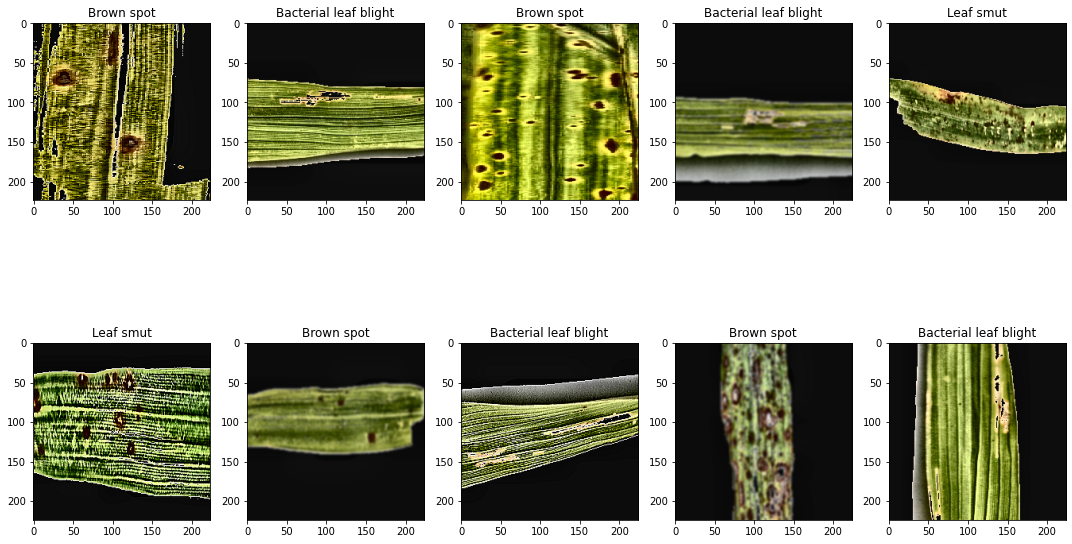

In [6]:
#Visualize images in training dataset
fig, axes = plt.subplots(2, 5, figsize = (15,10))
#TRUE LABEL of Training Data
for index in range(10):   
    ax = axes[index//5, index%5]
    ax.imshow(X_train[index])
    ax.set_title(classes[y_train[index]]) 
plt.tight_layout()
plt.show()

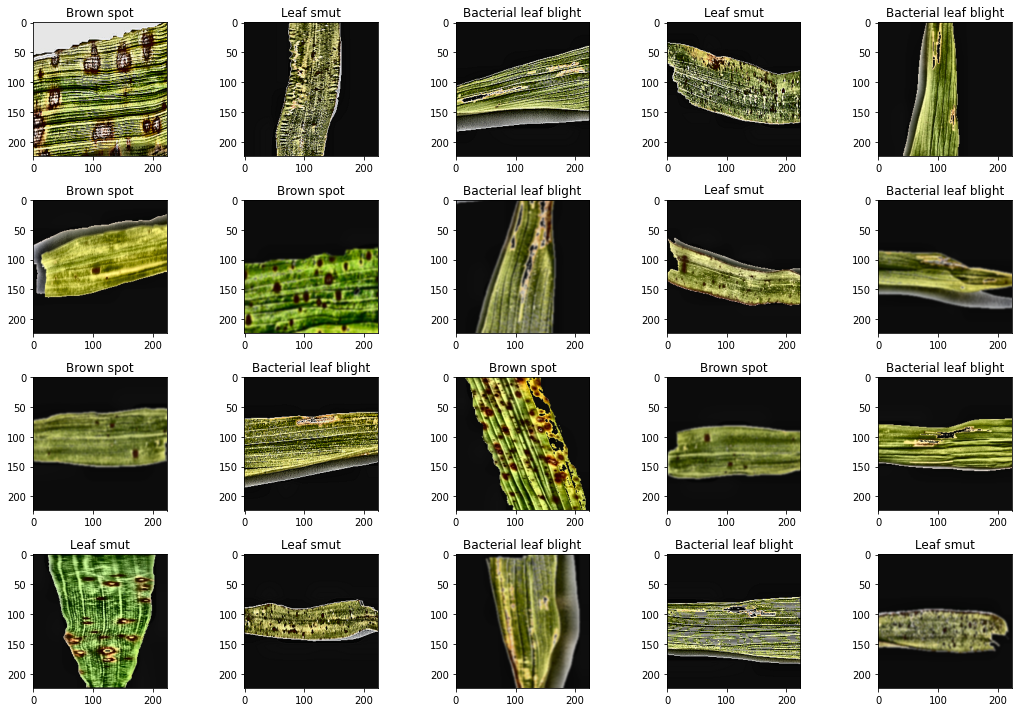

In [7]:
#Visualize images in testing dataset
fig, axes = plt.subplots(4, 5, figsize = (15,10))
#TRUE LABEL of Testing Data
for index in range(20):   
    ax = axes[index//5, index%5]
    ax.imshow(X_test[index])
    ax.set_title(classes[y_test[index]]) 
plt.tight_layout()
plt.show()

# 2. Define Visual Attention, Early Stopping, Checkpoints, and CSVLogger

In [8]:
#From https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/0%20-%20TF2.X%20Tutorials/tf_2_visual_attention.ipynb
#By EscVM
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)
            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)
            max_pool = self.shared_layer_one(max_pool)
            max_pool = self.shared_layer_two(max_pool)

            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)
            
            return tf.keras.layers.Multiply()([inputs, attention])
    
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])
            attention = self.conv2d(attention)
            
            return tf.keras.layers.multiply([inputs, attention]) 

In [9]:
# set early stopping criteria
pat = 5 # this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1, baseline=None)

# define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint(f'model_checkpoints/acnn_model.h5', verbose=1, save_best_only=True)

# to save the history of models
csv_logger = CSVLogger(f'logs/acnn_model.log', separator=",", append=True)

#Kernel_regulizer to minimize overfitting/underfitting of model
regularizer = regularizers.l2(0.00020)

# 3. CNN Models

## 3.1 CNN Model with no Visual Attention

#### 3.1.1 Training CNN Model

In [10]:
#AlexNet CNN Model with no visual attention
def build_model_no_attention():
    
    acnn_model = Sequential()
    optimizer = tf.keras.optimizers.Adam(0.0000088)
    
    acnn_model.add(Conv2D(filters = 96, kernel_size = (11,11), strides = (4,4), padding = 'same', activation = 'relu',
                      input_shape = (224,224,3), data_format = 'channels_last'))
    # acnn_model.add(Lambda(tf.nn.local_response_normalization))
    acnn_model.add(BatchNormalization())
    acnn_model.add(MaxPool2D(pool_size =(3,3), strides = (2,2)))


    acnn_model.add(Conv2D(filters = 256, kernel_size = (5,5), strides=(1,1), padding='same', activation = 'relu'))
    # acnn_model.add(Lambda(tf.nn.local_response_normalization))
    acnn_model.add(BatchNormalization())
    acnn_model.add(MaxPool2D(pool_size =(3,3), strides = (2,2)))

    acnn_model.add(Conv2D(filters = 384, kernel_size = (3,3), strides=(1,1), padding='same', activation = 'relu'))
    # acnn_model.add(Lambda(tf.nn.local_response_normalization))
    acnn_model.add(BatchNormalization())
    acnn_model.add(Conv2D(filters = 384, kernel_size = (3,3), strides=(1,1), padding='same', activation = 'relu'))
    # acnn_model.add(Lambda(tf.nn.local_response_normalization))
    acnn_model.add(BatchNormalization())
    acnn_model.add(Conv2D(filters = 256, kernel_size = (3,3), strides=(1,1), padding='same', activation = 'relu'))
    # acnn_model.add(Lambda(tf.nn.local_response_normalization))
    acnn_model.add(BatchNormalization())
    acnn_model.add(MaxPool2D(pool_size = (3,3), strides = (2,2) ))

    acnn_model.add(Flatten())
    acnn_model.add(Dense(100, activation ='relu', kernel_regularizer= regularizer))
    acnn_model.add(Dropout(0.5))

    acnn_model.add(Dense(100, activation ='relu',kernel_regularizer= regularizer))
    acnn_model.add(Dropout(0.5))

    acnn_model.add(Dense(3, activation = 'softmax'))

    
    acnn_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics= ['accuracy'])

    return acnn_model


In [11]:
#Define AlexNet model and Train
acnn_model = build_model_no_attention()
acnn_hist = acnn_model.fit(X_train, y_train, verbose = 1, batch_size = 32, validation_split = 0.1111111111,
                   epochs=50, callbacks = [early_stopping, model_checkpoint, csv_logger])

Epoch 1/50
63/63 [==============================] - 8s 47ms/step - loss: 2.1716 - accuracy: 0.3433 - val_loss: 1.1673 - val_accuracy: 0.3690

Epoch 00001: val_loss improved from inf to 1.16725, saving model to model_checkpoints\acnn_model.h5
Epoch 2/50
63/63 [==============================] - 2s 38ms/step - loss: 1.3859 - accuracy: 0.3943 - val_loss: 1.1061 - val_accuracy: 0.4286

Epoch 00002: val_loss improved from 1.16725 to 1.10615, saving model to model_checkpoints\acnn_model.h5
Epoch 3/50
63/63 [==============================] - 2s 37ms/step - loss: 1.1789 - accuracy: 0.4157 - val_loss: 1.0938 - val_accuracy: 0.4722

Epoch 00003: val_loss improved from 1.10615 to 1.09380, saving model to model_checkpoints\acnn_model.h5
Epoch 4/50
63/63 [==============================] - 2s 38ms/step - loss: 1.1181 - accuracy: 0.4271 - val_loss: 1.0886 - val_accuracy: 0.4921

Epoch 00004: val_loss improved from 1.09380 to 1.08864, saving model to model_checkpoints\acnn_model.h5
Epoch 5/50
63/63 [==

#### 3.1.2 Visualization of Train-Validation Accuracy and Loss 

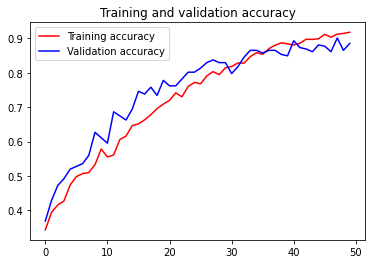

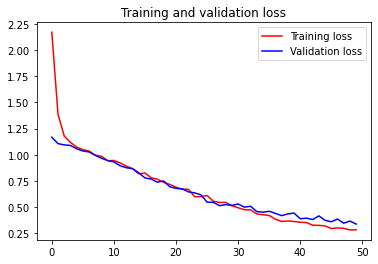

In [12]:
#Visualization of Train-Validation Accuracy and Loss
accuracy = acnn_hist.history['accuracy']
val_accuracy = acnn_hist.history['val_accuracy']
loss = acnn_hist.history['loss']
val_loss = acnn_hist.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### 3.1.3 Model Evaluation on Testing Dataset and Summary of Model's structure

In [13]:
#Accuracy of the model based on the testing:
acnn_model.evaluate(X_test,y_test)

8/8 [==============================] - 0s 14ms/step - loss: 0.4022 - accuracy: 0.8929


[0.4021739065647125, 0.8928571343421936]

In [14]:
acnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       8

In [15]:
#Get the label predictions of acnn_model
y_pred = acnn_model.predict(X_test)
na_pred_classes = [np.argmax(element) for element in y_pred]

[Text(0, 0.5, 'BLB'), Text(0, 1.5, 'Brown spot'), Text(0, 2.5, 'Leaf smut')]

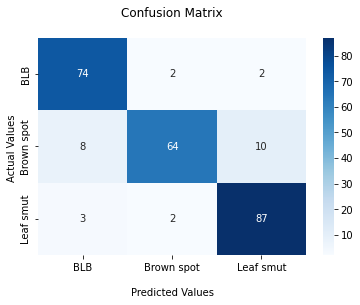

In [16]:
#Show the confusion matrix
classes_shortened = ["BLB", "Brown spot", "Leaf smut"]
conf_matrix = confusion_matrix(y_test, na_pred_classes)
ax = sb.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(classes_shortened)
ax.yaxis.set_ticklabels(classes_shortened)

In [17]:
print("Classification Report: \n", classification_report(y_test, na_pred_classes, target_names=["Bacterial leaf blight", "Brown spot", "Leaf smut"]))

Classification Report: 
                        precision    recall  f1-score   support

Bacterial leaf blight       0.87      0.95      0.91        78
           Brown spot       0.94      0.78      0.85        82
            Leaf smut       0.88      0.95      0.91        92

             accuracy                           0.89       252
            macro avg       0.90      0.89      0.89       252
         weighted avg       0.90      0.89      0.89       252



In [18]:
#Display the error rate:
accuracy = accuracy_score(y_test, na_pred_classes)
print('Error: %.3f' % ((1-accuracy) * 100) + '%')

Error: 10.714%


## 3.2 CNN Model with Attention

#### 3.2.1 Training CNN Model

In [19]:
#AlexNet CNN Model with visual attention
def build_model_with_attention():
    acnn_model_wa = Sequential()
    
    optimizer = tf.keras.optimizers.Adam(0.0000088)
    
    acnn_model_wa.add(Conv2D(filters = 96, kernel_size = (11,11), strides = (4,4), padding = 'same', activation = 'relu',
                      input_shape = (224,224,3), data_format = 'channels_last'))

    # acnn_model_wa.add(Lambda(tf.nn.local_response_normalization))
    acnn_model_wa.add(BatchNormalization())

    #Implement Visual Attention
    acnn_model_wa.add(ChannelAttention(96,5))
    acnn_model_wa.add(SpatialAttention(3))

    acnn_model_wa.add(MaxPool2D(pool_size =(3,3), strides = (2,2)))


    acnn_model_wa.add(Conv2D(filters = 256, kernel_size = (5,5), strides=(1,1), padding='same', activation = 'relu'))

    # acnn_model_wa.add(Lambda(tf.nn.local_response_normalization))
    acnn_model_wa.add(BatchNormalization())

    #Implement Visual Attention
    acnn_model_wa.add(ChannelAttention(256,5))
    acnn_model_wa.add(SpatialAttention(3))

    acnn_model_wa.add(MaxPool2D(pool_size =(3,3), strides = (2,2)))

    acnn_model_wa.add(Conv2D(filters = 384, kernel_size = (3,3), strides=(1,1), padding='same', activation = 'relu'))


    # acnn_model_wa.add(Lambda(tf.nn.local_response_normalization))
    acnn_model_wa.add(BatchNormalization())

    #Implement Visual Attention
    acnn_model_wa.add(ChannelAttention(384,5))
    acnn_model_wa.add(SpatialAttention(3))

    acnn_model_wa.add(Conv2D(filters = 384, kernel_size = (3,3), strides=(1,1), padding='same', activation = 'relu'))


    # acnn_model_wa.add(Lambda(tf.nn.local_response_normalization))
    acnn_model_wa.add(BatchNormalization())

    #Implement Visual Attention
    acnn_model_wa.add(ChannelAttention(384,5))
    acnn_model_wa.add(SpatialAttention(3))

    acnn_model_wa.add(Conv2D(filters = 256, kernel_size = (3,3), strides=(1,1), padding='same', activation = 'relu'))


    # acnn_model_wa.add(Lambda(tf.nn.local_response_normalization))
    acnn_model_wa.add(BatchNormalization())

    #Implement Visual Attention
    acnn_model_wa.add(ChannelAttention(256,5))
    acnn_model_wa.add(SpatialAttention(3))

    acnn_model_wa.add(MaxPool2D(pool_size = (3,3), strides = (2,2) ))

    acnn_model_wa.add(Flatten())
    acnn_model_wa.add(Dense(100, activation ='relu', kernel_regularizer= regularizer))
    acnn_model_wa.add(Dropout(0.5))

    acnn_model_wa.add(Dense(100, activation ='relu', kernel_regularizer= regularizer))
    acnn_model_wa.add(Dropout(0.5))

    acnn_model_wa.add(Dense(3, activation = 'softmax'))

    
    acnn_model_wa.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics= ['accuracy'])

    return acnn_model_wa


In [20]:
acnn_model_wa = build_model_with_attention()
acnn_wa_hist = acnn_model_wa.fit(X_train, y_train, verbose = 1, batch_size = 32, validation_split = 0.1111111111,
                   epochs=50, callbacks = [early_stopping, csv_logger])
    

Epoch 1/50
63/63 [==============================] - 3s 41ms/step - loss: 2.0013 - accuracy: 0.3442 - val_loss: 1.1531 - val_accuracy: 0.3849
Epoch 2/50
63/63 [==============================] - 2s 38ms/step - loss: 1.3344 - accuracy: 0.3894 - val_loss: 1.1092 - val_accuracy: 0.4246
Epoch 3/50
63/63 [==============================] - 2s 38ms/step - loss: 1.1887 - accuracy: 0.4097 - val_loss: 1.0973 - val_accuracy: 0.5079
Epoch 4/50
63/63 [==============================] - 2s 38ms/step - loss: 1.1013 - accuracy: 0.4504 - val_loss: 1.0625 - val_accuracy: 0.5278
Epoch 5/50
63/63 [==============================] - 2s 38ms/step - loss: 1.0627 - accuracy: 0.4752 - val_loss: 1.0228 - val_accuracy: 0.5397
Epoch 6/50
63/63 [==============================] - 2s 38ms/step - loss: 1.0438 - accuracy: 0.4955 - val_loss: 1.0009 - val_accuracy: 0.5754
Epoch 7/50
63/63 [==============================] - 2s 38ms/step - loss: 1.0035 - accuracy: 0.5218 - val_loss: 0.9622 - val_accuracy: 0.5833
Epoch 8/50
63

#### 3.2.2 Visualization of Train-Validation Accuracy and Loss 

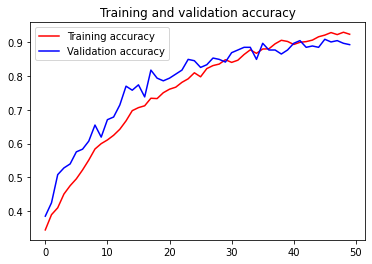

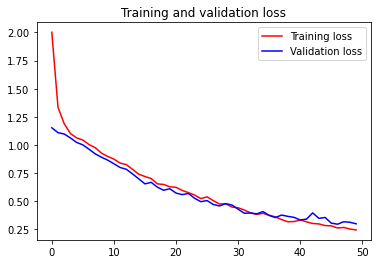

In [21]:
#Visualization of Train-Validation Accuracy and Loss
accuracy = acnn_wa_hist.history['accuracy']
val_accuracy = acnn_wa_hist.history['val_accuracy']
loss = acnn_wa_hist.history['loss']
val_loss = acnn_wa_hist.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### 3.2.3 Model Evaluation on Testing Dataset and Summary of Model's structure

In [22]:
acnn_model_wa.evaluate(X_test,y_test)

8/8 [==============================] - 0s 14ms/step - loss: 0.4171 - accuracy: 0.8770


[0.4171041250228882, 0.8769841194152832]

In [23]:
acnn_model_wa.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization_5 (Batch (None, 56, 56, 96)        384       
_________________________________________________________________
channel_attention (ChannelAt (None, 56, 56, 96)        0         
_________________________________________________________________
spatial_attention (SpatialAt (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_6 (Batch (None, 27, 27, 256)      

In [24]:
y_pred = acnn_model_wa.predict(X_test)
wa_pred_classes = [np.argmax(element) for element in y_pred]

[Text(0, 0.5, 'BLB'), Text(0, 1.5, 'Brown spot'), Text(0, 2.5, 'Leaf smut')]

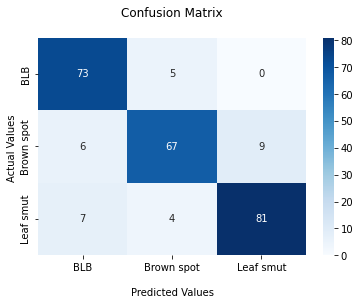

In [25]:
#Confusion Metrics:
classes_shortened = ["BLB", "Brown spot", "Leaf smut"]
conf_matrix = confusion_matrix(y_test, wa_pred_classes)
ax = sb.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')
ax.xaxis.set_ticklabels(classes_shortened)
ax.yaxis.set_ticklabels(classes_shortened) 

In [26]:
#Classification Report:
print("Classification Report: \n", classification_report(y_test, wa_pred_classes, target_names=["Bacterial leaf blight", "Brown spot", "Leaf smut"]))

Classification Report: 
                        precision    recall  f1-score   support

Bacterial leaf blight       0.85      0.94      0.89        78
           Brown spot       0.88      0.82      0.85        82
            Leaf smut       0.90      0.88      0.89        92

             accuracy                           0.88       252
            macro avg       0.88      0.88      0.88       252
         weighted avg       0.88      0.88      0.88       252



In [27]:
#Display the error rate:
accuracy = accuracy_score(y_test, wa_pred_classes)
print('Error: %.3f' % ((1-accuracy) * 100) + '%')

Error: 12.302%


# 4. K-Fold Cross Validation

### 4.1 Evaluation of Models using K-Fold

#### 4.1.1 CNN Model with no Visual Attention

In [28]:
#Change the no. of epochs
seed = 10
np.random.seed(seed)

skf = StratifiedKFold(n_splits=10, random_state= seed, shuffle = True)
cvscores = []
# X_dataset is the feature set and y_dataset is the target
for train_index, test_index in skf.split(X_dataset,y_dataset):
    acnn_model = build_model_no_attention()
    acnn_hist = acnn_model.fit(X_dataset[train_index], y_dataset[train_index], verbose = 1, batch_size = 16,
                               validation_split = 0.1111111111, epochs= 50)
    scores = acnn_model.evaluate(X_dataset[test_index], y_dataset[test_index])
    print("%s: %.2f%%" % (acnn_model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1]*100)


Epoch 1/50
126/126 [==============================] - 5s 25ms/step - loss: 2.1878 - accuracy: 0.3522 - val_loss: 1.1151 - val_accuracy: 0.4643
Epoch 2/50
126/126 [==============================] - 3s 22ms/step - loss: 1.3821 - accuracy: 0.4013 - val_loss: 1.0234 - val_accuracy: 0.5317
Epoch 3/50
126/126 [==============================] - 3s 22ms/step - loss: 1.1750 - accuracy: 0.4420 - val_loss: 0.9699 - val_accuracy: 0.6349
Epoch 4/50
126/126 [==============================] - 3s 22ms/step - loss: 1.0712 - accuracy: 0.4921 - val_loss: 0.9386 - val_accuracy: 0.6508
Epoch 5/50
126/126 [==============================] - 3s 22ms/step - loss: 1.0343 - accuracy: 0.5099 - val_loss: 0.8741 - val_accuracy: 0.6905
Epoch 6/50
126/126 [==============================] - 3s 22ms/step - loss: 0.9656 - accuracy: 0.5585 - val_loss: 0.8350 - val_accuracy: 0.7421
Epoch 7/50
126/126 [==============================] - 3s 22ms/step - loss: 0.9150 - accuracy: 0.6062 - val_loss: 0.7842 - val_accuracy: 0.7381

126/126 [==============================] - 3s 22ms/step - loss: 0.8458 - accuracy: 0.6190 - val_loss: 0.7506 - val_accuracy: 0.7341
Epoch 14/50
126/126 [==============================] - 3s 22ms/step - loss: 0.8455 - accuracy: 0.6225 - val_loss: 0.6909 - val_accuracy: 0.7698
Epoch 15/50
126/126 [==============================] - 3s 22ms/step - loss: 0.7899 - accuracy: 0.6424 - val_loss: 0.6665 - val_accuracy: 0.7738
Epoch 16/50
126/126 [==============================] - 3s 22ms/step - loss: 0.7717 - accuracy: 0.6726 - val_loss: 0.6482 - val_accuracy: 0.7698
Epoch 17/50
126/126 [==============================] - 3s 22ms/step - loss: 0.7113 - accuracy: 0.6954 - val_loss: 0.5883 - val_accuracy: 0.7976
Epoch 18/50
126/126 [==============================] - 3s 22ms/step - loss: 0.6883 - accuracy: 0.7247 - val_loss: 0.5678 - val_accuracy: 0.8016
Epoch 19/50
126/126 [==============================] - 3s 22ms/step - loss: 0.6748 - accuracy: 0.7252 - val_loss: 0.5873 - val_accuracy: 0.7976
Epoc

126/126 [==============================] - 3s 22ms/step - loss: 0.4212 - accuracy: 0.8651 - val_loss: 0.3979 - val_accuracy: 0.9206
Epoch 26/50
126/126 [==============================] - 3s 22ms/step - loss: 0.3790 - accuracy: 0.8770 - val_loss: 0.4113 - val_accuracy: 0.8849
Epoch 27/50
126/126 [==============================] - 3s 22ms/step - loss: 0.3910 - accuracy: 0.8775 - val_loss: 0.3585 - val_accuracy: 0.9206
Epoch 28/50
126/126 [==============================] - 3s 22ms/step - loss: 0.3563 - accuracy: 0.8943 - val_loss: 0.3542 - val_accuracy: 0.9167
Epoch 29/50
126/126 [==============================] - 3s 22ms/step - loss: 0.3362 - accuracy: 0.8938 - val_loss: 0.3673 - val_accuracy: 0.9008
Epoch 30/50
126/126 [==============================] - 3s 22ms/step - loss: 0.3421 - accuracy: 0.8919 - val_loss: 0.3274 - val_accuracy: 0.9286
Epoch 31/50
126/126 [==============================] - 3s 22ms/step - loss: 0.3097 - accuracy: 0.9107 - val_loss: 0.3531 - val_accuracy: 0.9167
Epoc

126/126 [==============================] - 3s 22ms/step - loss: 0.2813 - accuracy: 0.9191 - val_loss: 0.3336 - val_accuracy: 0.8849
Epoch 38/50
126/126 [==============================] - 3s 22ms/step - loss: 0.2600 - accuracy: 0.9251 - val_loss: 0.3027 - val_accuracy: 0.9206
Epoch 39/50
126/126 [==============================] - 3s 22ms/step - loss: 0.2522 - accuracy: 0.9266 - val_loss: 0.3735 - val_accuracy: 0.8770
Epoch 40/50
126/126 [==============================] - 3s 22ms/step - loss: 0.2574 - accuracy: 0.9211 - val_loss: 0.3408 - val_accuracy: 0.9048
Epoch 41/50
126/126 [==============================] - 3s 22ms/step - loss: 0.2309 - accuracy: 0.9306 - val_loss: 0.3032 - val_accuracy: 0.9008
Epoch 42/50
126/126 [==============================] - 3s 22ms/step - loss: 0.2312 - accuracy: 0.9345 - val_loss: 0.3156 - val_accuracy: 0.9087
Epoch 43/50
126/126 [==============================] - 3s 22ms/step - loss: 0.2482 - accuracy: 0.9311 - val_loss: 0.3815 - val_accuracy: 0.8770
Epoc

126/126 [==============================] - 3s 22ms/step - loss: 0.1867 - accuracy: 0.9568 - val_loss: 0.2146 - val_accuracy: 0.9484
Epoch 50/50
8/8 [==============================] - 0s 14ms/step - loss: 0.3033 - accuracy: 0.9286
accuracy: 92.86%
Epoch 1/50
126/126 [==============================] - 4s 23ms/step - loss: 1.7912 - accuracy: 0.3651 - val_loss: 1.1468 - val_accuracy: 0.4087
Epoch 2/50
126/126 [==============================] - 3s 22ms/step - loss: 1.2649 - accuracy: 0.4062 - val_loss: 1.0854 - val_accuracy: 0.5357
Epoch 3/50
126/126 [==============================] - 3s 22ms/step - loss: 1.1468 - accuracy: 0.4291 - val_loss: 1.0541 - val_accuracy: 0.5159
Epoch 4/50
126/126 [==============================] - 3s 22ms/step - loss: 1.1027 - accuracy: 0.4474 - val_loss: 1.0253 - val_accuracy: 0.5675
Epoch 5/50
126/126 [==============================] - 3s 22ms/step - loss: 1.0702 - accuracy: 0.4787 - val_loss: 0.9924 - val_accuracy: 0.6151
Epoch 6/50
126/126 [==================

#### 4.1.1.1 Overall Performance of CNN model without Visual Attention

In [29]:
print("%.2f%% (+/-%.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

92.06% (+/-2.50%)


#### 4.1.2 CNN Model with Visual Attention

In [30]:
#Change the no. of epochs
seed = 10
np.random.seed(seed)

skf = StratifiedKFold(n_splits=10, random_state= seed, shuffle = True)
cvscores = []
# X_dataset is the feature set and y_dataset is the target
for train_index, test_index in skf.split(X_dataset,y_dataset):
    acnn_model_wa = build_model_with_attention()
    acnn_wa_hist = acnn_model_wa.fit(X_dataset[train_index], y_dataset[train_index], 
                                     verbose = 1, batch_size = 16,validation_split = 0.1111111111, epochs=50)
    scores = acnn_model_wa.evaluate(X_dataset[test_index], y_dataset[test_index])
    print("%s: %.2f%%" % (acnn_model_wa.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1]*100)


Epoch 1/50
126/126 [==============================] - 4s 23ms/step - loss: 1.8125 - accuracy: 0.3740 - val_loss: 1.1098 - val_accuracy: 0.4762
Epoch 2/50
126/126 [==============================] - 3s 22ms/step - loss: 1.2319 - accuracy: 0.4132 - val_loss: 1.0266 - val_accuracy: 0.5556
Epoch 3/50
126/126 [==============================] - 3s 22ms/step - loss: 1.0939 - accuracy: 0.4588 - val_loss: 0.9920 - val_accuracy: 0.6270
Epoch 4/50
126/126 [==============================] - 3s 22ms/step - loss: 1.0537 - accuracy: 0.4802 - val_loss: 0.9488 - val_accuracy: 0.6429
Epoch 5/50
126/126 [==============================] - 3s 22ms/step - loss: 1.0214 - accuracy: 0.5327 - val_loss: 0.8912 - val_accuracy: 0.6905
Epoch 6/50
126/126 [==============================] - 3s 22ms/step - loss: 0.9803 - accuracy: 0.5585 - val_loss: 0.8439 - val_accuracy: 0.7024
Epoch 7/50
126/126 [==============================] - 3s 22ms/step - loss: 0.9347 - accuracy: 0.5784 - val_loss: 0.8125 - val_accuracy: 0.7302

126/126 [==============================] - 3s 22ms/step - loss: 0.6833 - accuracy: 0.7272 - val_loss: 0.6012 - val_accuracy: 0.7897
Epoch 14/50
126/126 [==============================] - 3s 22ms/step - loss: 0.6487 - accuracy: 0.7579 - val_loss: 0.5764 - val_accuracy: 0.8254
Epoch 15/50
126/126 [==============================] - 3s 22ms/step - loss: 0.5991 - accuracy: 0.7832 - val_loss: 0.5563 - val_accuracy: 0.8095
Epoch 16/50
126/126 [==============================] - 3s 22ms/step - loss: 0.5814 - accuracy: 0.7788 - val_loss: 0.5366 - val_accuracy: 0.8294
Epoch 17/50
126/126 [==============================] - 3s 22ms/step - loss: 0.5682 - accuracy: 0.7867 - val_loss: 0.5007 - val_accuracy: 0.8452
Epoch 18/50
126/126 [==============================] - 3s 22ms/step - loss: 0.5217 - accuracy: 0.8175 - val_loss: 0.4739 - val_accuracy: 0.8690
Epoch 19/50
126/126 [==============================] - 3s 22ms/step - loss: 0.5314 - accuracy: 0.8150 - val_loss: 0.4551 - val_accuracy: 0.8413
Epoc

126/126 [==============================] - 3s 22ms/step - loss: 0.3789 - accuracy: 0.8725 - val_loss: 0.3646 - val_accuracy: 0.8968
Epoch 26/50
126/126 [==============================] - 3s 22ms/step - loss: 0.3458 - accuracy: 0.8909 - val_loss: 0.3745 - val_accuracy: 0.8849
Epoch 27/50
126/126 [==============================] - 3s 22ms/step - loss: 0.3361 - accuracy: 0.8963 - val_loss: 0.3316 - val_accuracy: 0.9008
Epoch 28/50
126/126 [==============================] - 3s 22ms/step - loss: 0.3297 - accuracy: 0.8953 - val_loss: 0.3190 - val_accuracy: 0.8968
Epoch 29/50
126/126 [==============================] - 3s 22ms/step - loss: 0.3022 - accuracy: 0.9102 - val_loss: 0.3003 - val_accuracy: 0.9246
Epoch 30/50
126/126 [==============================] - 3s 22ms/step - loss: 0.3013 - accuracy: 0.9097 - val_loss: 0.3197 - val_accuracy: 0.9206
Epoch 31/50
126/126 [==============================] - 3s 22ms/step - loss: 0.2957 - accuracy: 0.9092 - val_loss: 0.2859 - val_accuracy: 0.9286
Epoc

126/126 [==============================] - 3s 22ms/step - loss: 0.2943 - accuracy: 0.9112 - val_loss: 0.3080 - val_accuracy: 0.9206
Epoch 38/50
126/126 [==============================] - 3s 22ms/step - loss: 0.2881 - accuracy: 0.9167 - val_loss: 0.2859 - val_accuracy: 0.9246
Epoch 39/50
126/126 [==============================] - 3s 22ms/step - loss: 0.2926 - accuracy: 0.9082 - val_loss: 0.3394 - val_accuracy: 0.8968
Epoch 40/50
126/126 [==============================] - 3s 22ms/step - loss: 0.2605 - accuracy: 0.9231 - val_loss: 0.3263 - val_accuracy: 0.9127
Epoch 41/50
126/126 [==============================] - 3s 22ms/step - loss: 0.2594 - accuracy: 0.9201 - val_loss: 0.4125 - val_accuracy: 0.8849
Epoch 42/50
126/126 [==============================] - 3s 22ms/step - loss: 0.2413 - accuracy: 0.9315 - val_loss: 0.3232 - val_accuracy: 0.9087
Epoch 43/50
126/126 [==============================] - 3s 22ms/step - loss: 0.2356 - accuracy: 0.9355 - val_loss: 0.2751 - val_accuracy: 0.9286
Epoc

126/126 [==============================] - 3s 22ms/step - loss: 0.2206 - accuracy: 0.9444 - val_loss: 0.2271 - val_accuracy: 0.9524
Epoch 50/50
8/8 [==============================] - 0s 14ms/step - loss: 0.2671 - accuracy: 0.9286
accuracy: 92.86%
Epoch 1/50
126/126 [==============================] - 4s 23ms/step - loss: 1.7924 - accuracy: 0.3636 - val_loss: 1.1094 - val_accuracy: 0.4087
Epoch 2/50
126/126 [==============================] - 3s 22ms/step - loss: 1.2133 - accuracy: 0.4147 - val_loss: 1.0747 - val_accuracy: 0.4881
Epoch 3/50
126/126 [==============================] - 3s 22ms/step - loss: 1.1022 - accuracy: 0.4559 - val_loss: 1.0212 - val_accuracy: 0.5357
Epoch 4/50
126/126 [==============================] - 3s 22ms/step - loss: 1.0555 - accuracy: 0.5060 - val_loss: 0.9419 - val_accuracy: 0.6429
Epoch 5/50
126/126 [==============================] - 3s 22ms/step - loss: 1.0311 - accuracy: 0.5099 - val_loss: 0.8993 - val_accuracy: 0.6786
Epoch 6/50
126/126 [==================

#### 4.1.2.1 Overall Performance of CNN model with Visual Attention

In [31]:
print("%.2f%% (+/-%.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

92.38% (+/-1.64%)


### 4.2 Visualization from split of K-Fold

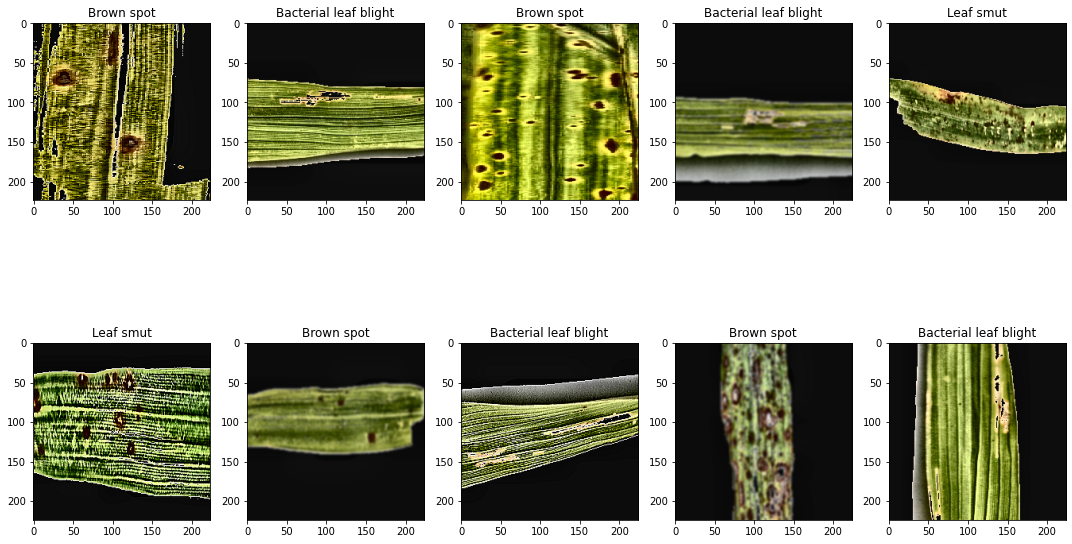

In [32]:
#Visualize images in training dataset
fig, axes = plt.subplots(2, 5, figsize = (15,10))
#TRUE LABEL of Training Data
for index in range(10):   
    ax = axes[index//5, index%5]
    ax.imshow(X_train[index])
    ax.set_title(classes[y_train[index]]) 
plt.tight_layout()
plt.show()

# 5. Comparison of CNN model w/ and w/o Attention

### 5.1 Visualization of TRUE and PREDICTED Labels

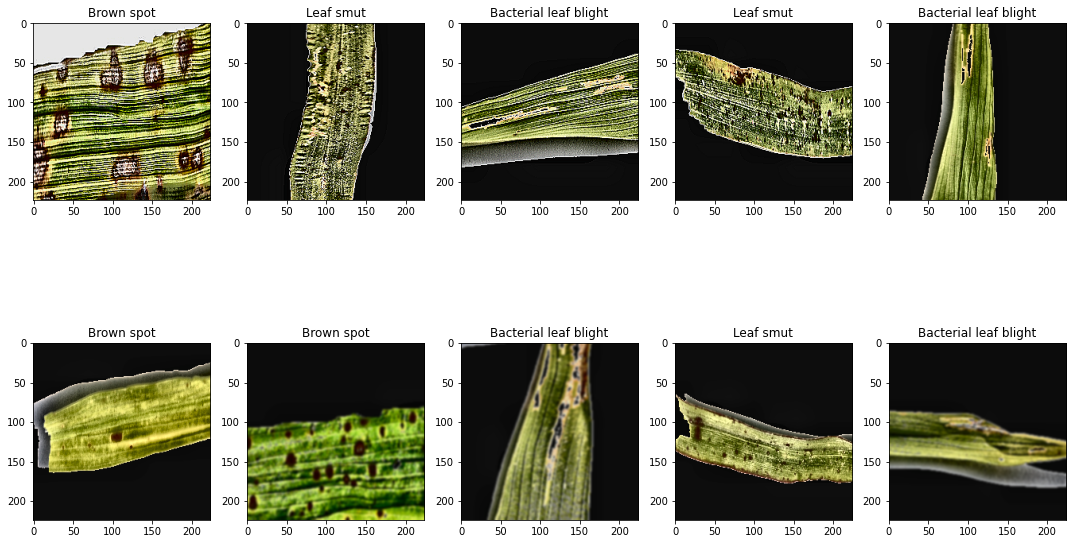

In [33]:
# True Labels
fig, axes = plt.subplots(2, 5, figsize = (15,10))
#TRUE LABEL of Testing DATASET
for index in range(10):   
#     plt.figure(figsize = (15,2))
    ax = axes[index//5, index%5]
    ax.imshow(X_test[index])
    ax.set_title(classes[y_test[index]]) 
plt.tight_layout()
plt.show()

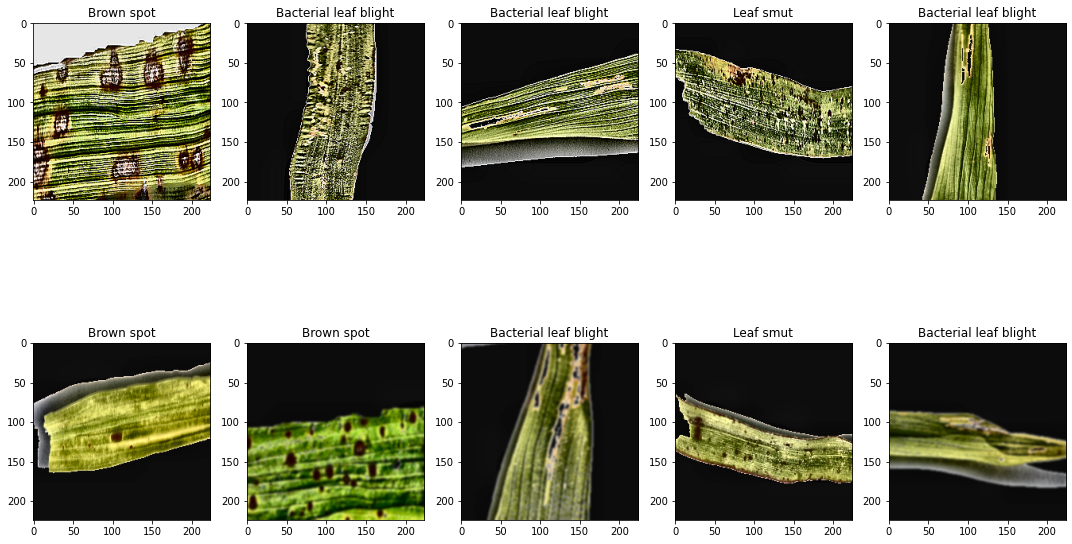

In [34]:
# Predicted Labels

fig, axes = plt.subplots(2, 5, figsize = (15,10))
#PREDICTED LABEL of ACNN model with no attention
for index in range(10):   
#     plt.figure(figsize = (15,2))
    ax = axes[index//5, index%5]
    ax.imshow(X_test[index])
    ax.set_title(classes[wa_pred_classes[index]]) 
plt.tight_layout()
plt.show()

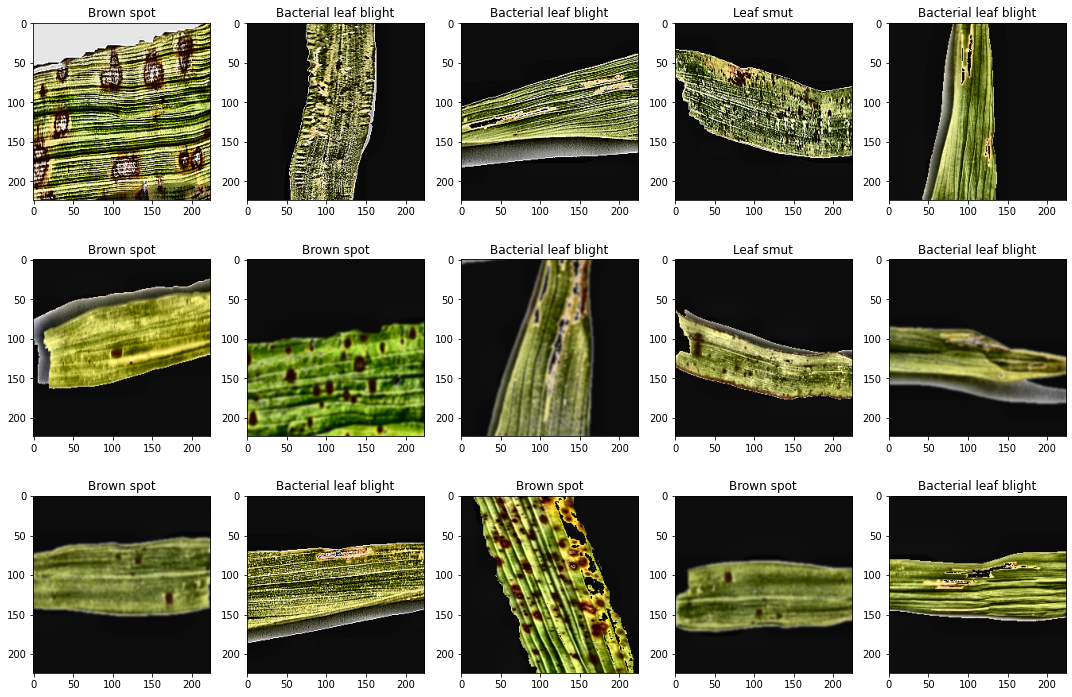

In [35]:
#PREDICTED LABEL of ACNN model with attention

fig, axes = plt.subplots(3, 5, figsize = (15,10))
#PREDICTED LABEL of ACNN model with attention
for index in range(15):   
#     plt.figure(figsize = (15,2))
    ax = axes[index//5, index%5]
    ax.imshow(X_test[index])
    ax.set_title(classes[wa_pred_classes[index]]) 
plt.tight_layout()
plt.show()